# Intro

This notebook contains:
* basic analysis of select automated speech recognition (ASR) datasets
* example usage of a script to preprocess data to a unified format
* example usage of a script for ASR (predicting text from audio samples)
* example usage of a script computing metrics (WER, CER)
* visualization and interpretation of the computed metrics

**We recommend running speech recognition (`Speech recognition` subsections for respective datasets) on a dedicated machine due to potentially high RAM and GPU memory requirements and long runtime.** Your local machine or the free version of Google Colab might not satisfy these requirements.

# Environment setup

In [1]:
import os
import sys

In [2]:
ROOT_DIRPATH = os.getcwd()
SRC_DIRPATH = os.path.join(ROOT_DIRPATH, 'src')
DATASETS_DIRPATH = os.path.join(ROOT_DIRPATH, 'datasets')

COMMON_VOICE_DATA_DIRPATH = os.path.join(DATASETS_DIRPATH, 'Mozilla Common Voice')
FLEURS_DATA_DIRPATH = os.path.join(DATASETS_DIRPATH, 'FLEURS', 'dataset')

GENDER_COL = 'gender'
GROUND_TRUTH_RAW_COL = 'transcription_raw'
GROUND_TRUTH_COL = 'transcription_target'
PREDICTED_RAW_COL_PREFIX = 'transcription_predicted_raw_'
PREDICTED_COL_PREFIX = 'transcription_predicted_'
HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL = 'has_sentence_male_and_female_gender'
AUDIO_PATH_COL = 'path'

In [ ]:
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

if SRC_DIRPATH not in sys.path:
  sys.path.append(SRC_DIRPATH)

%aimport bisk_metrics
%aimport bisk_plot
%aimport bisk_preprocessing

In [ ]:
sns.set_theme(style='whitegrid')

In [ ]:
def get_filtered_cols(df, affixes_to_match):
  return [col for col in df.columns if all(affix in col for affix in affixes_to_match)]

# Dataset format

Each dataset is preprocessed to contain several columns that are used in preprocessing and evaluation. These columns have the same name and meaning across all datasets.

* `gender` column contains gender of the person recording text, e.g. `male`, `female`, `other` or `unknown`
* `transcription_target` contains text to be used in prediction as the ground truth
* `transcription_predicted_raw_*` columns contain data predicted by models. The data can contain more than predicted text, depending on the model and the prediction API used.
* `transcription_predicted_*` columns contain text predicted by models and processed the same way `transcription_target` was
* `has_sentence_male_and_female_gender` is `True` if a transcription is recorded by at least one male and at least one female, `False` otherwise
* `path` contains path to an audio sample corresponding to a transcription. The path is relative to the root directory of the corresponding dataset.

# FLEURS

## Common variables

In [ ]:
DATA_DIRPATH = FLEURS_DATA_DIRPATH
CACHE_DIRPATH = os.path.join(DATA_DIRPATH, 'cache')
METRICS_DIRPATH = os.path.join(DATA_DIRPATH, 'metrics')
PREPROCESSED_DATA_FILEPATH = os.path.join(DATA_DIRPATH, 'data_preprocessed.parquet')
DATA_WITH_PREDICTIONS_FILEPATH = os.path.join(DATA_DIRPATH, 'data_with_predictions.parquet')

DATASET_NAME = 'FLEURS'

## Downloading and preprocessing dataset

Both the download and the preprocessing of the FLEURS dataset is performed by the `preprocess_fleurs.py` script.

In [ ]:
!python "$SRC_DIRPATH"'/preprocess_fleurs.py' \
  '--data-dirpath' "$DATA_DIRPATH" \
  '--output-path' "$PREPROCESSED_DATA_FILEPATH" \
  '--cache-dirpath' "$CACHE_DIRPATH"

## Basic statistics

In [ ]:
df = pd.read_parquet(PREPROCESSED_DATA_FILEPATH)

In [ ]:
df.head()

,id,num_samples,path,audio,transcription,raw_transcription,gender_number,lang_id,language,lang_group_id,subset,gender,transcription_target,has_sentence_male_and_female_gender,sample_rate,bits_per_sample,num_channels,num_frames,encoding
0,97,138240,audio/train/16713473932221032184.wav,"{'bytes': None, 'path': '/root/.cache/huggingf...",od 70. rokov patril il-76 k pilierom ruskej aj...,Od 70. rokov patril Il-76 k pilierom ruskej aj...,0,80,Slovak,1,train,male,od 70 rokov patril il-76 k pilierom ruskej aj ...,False,16000,32,1,138240,PCM_F
1,139,119040,audio/train/7839683760275944614.wav,"{'bytes': None, 'path': '/root/.cache/huggingf...",na človeka môže pôsobiť dýchanie zasiahnutej v...,Na človeka môže pôsobiť dýchanie zasiahnutej v...,1,80,Slovak,1,train,female,na človeka môže pôsobiť dýchanie zasiahnutej v...,True,16000,32,1,119040,PCM_F
2,411,284160,audio/train/5982282738451859055.wav,"{'bytes': None, 'path': '/root/.cache/huggingf...",vynález lúčových kolies spôsobil že asýrske vo...,"Vynález lúčových kolies spôsobil, že asýrske v...",0,80,Slovak,1,train,male,vynález lúčových kolies spôsobil že asýrske vo...,True,16000,32,1,284160,PCM_F
3,702,152640,audio/train/11161626234888113486.wav,"{'bytes': None, 'path': '/root/.cache/huggingf...",kubánski občania ktorí sú držiteľmi zelenej ka...,"Kubánski občania, ktorí sú držiteľmi zelenej k...",0,80,Slovak,1,train,male,kubánski občania ktorí sú držiteľmi zelenej ka...,True,16000,32,1,152640,PCM_F
4,368,205440,audio/train/17992905545923686048.wav,"{'bytes': None, 'path': '/root/.cache/huggingf...",krv zo srdca odchádza v trubiciach tepnách a v...,Krv zo srdca odchádza v trubiciach - tepnách a...,1,80,Slovak,1,train,female,krv zo srdca odchádza v trubiciach tepnách a v...,True,16000,32,1,205440,PCM_F


In [ ]:
print('Number of all sentences:', len(df[GROUND_TRUTH_COL]))
print('Number of unique sentences:', len(df[GROUND_TRUTH_COL].unique()))
print('Number of sentences recorded by both male and female voice:', len(df[df[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL]]))
print(
    'Number of unique sentences recorded by both male and female voice:',
    len(df.loc[df[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL], GROUND_TRUTH_COL].unique()))

Number of all sentences: 3101
Number of unique sentences: 1719
Number of sentences recorded by both male and female voice: 1292
Number of unique sentences recorded by both male and female voice: 533


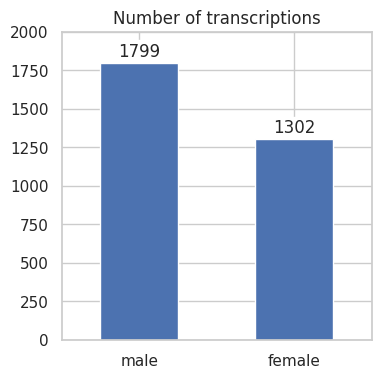

In [ ]:
ax = bisk_plot.plot_counts_per_gender(df, GENDER_COL, 'Number of transcriptions', ylim=2000)

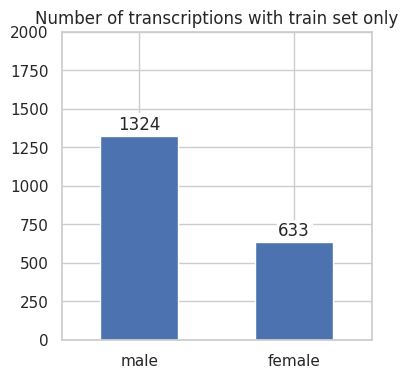

In [ ]:
ax = bisk_plot.plot_counts_per_gender(
  df[df['subset'] == 'train'], GENDER_COL, 'Number of transcriptions with train set only', ylim=2000)

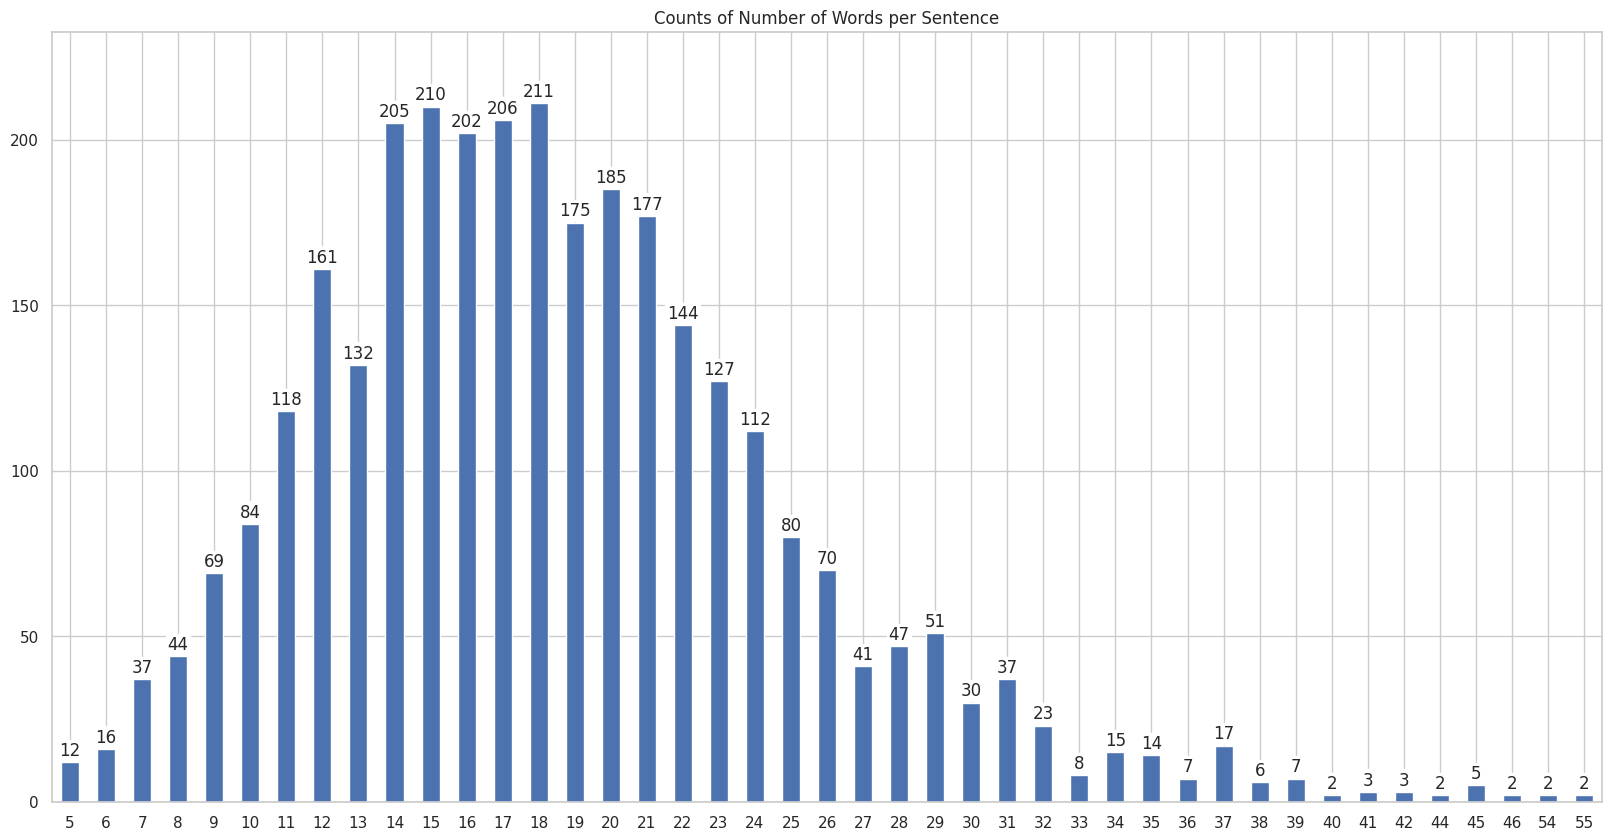

In [ ]:
ax = bisk_plot.plot_word_counts(df, GROUND_TRUTH_COL, 'Counts of Number of Words per Sentence')

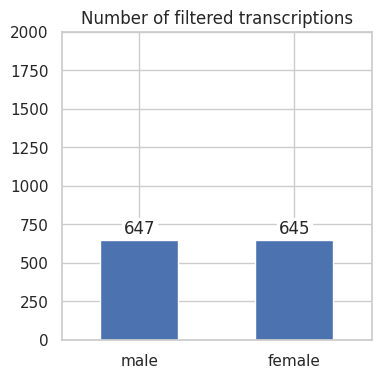

In [ ]:
ax = bisk_plot.plot_counts_per_gender(
    df[df[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL]],
    GENDER_COL,
    'Number of filtered transcriptions',
    ylim=2000)

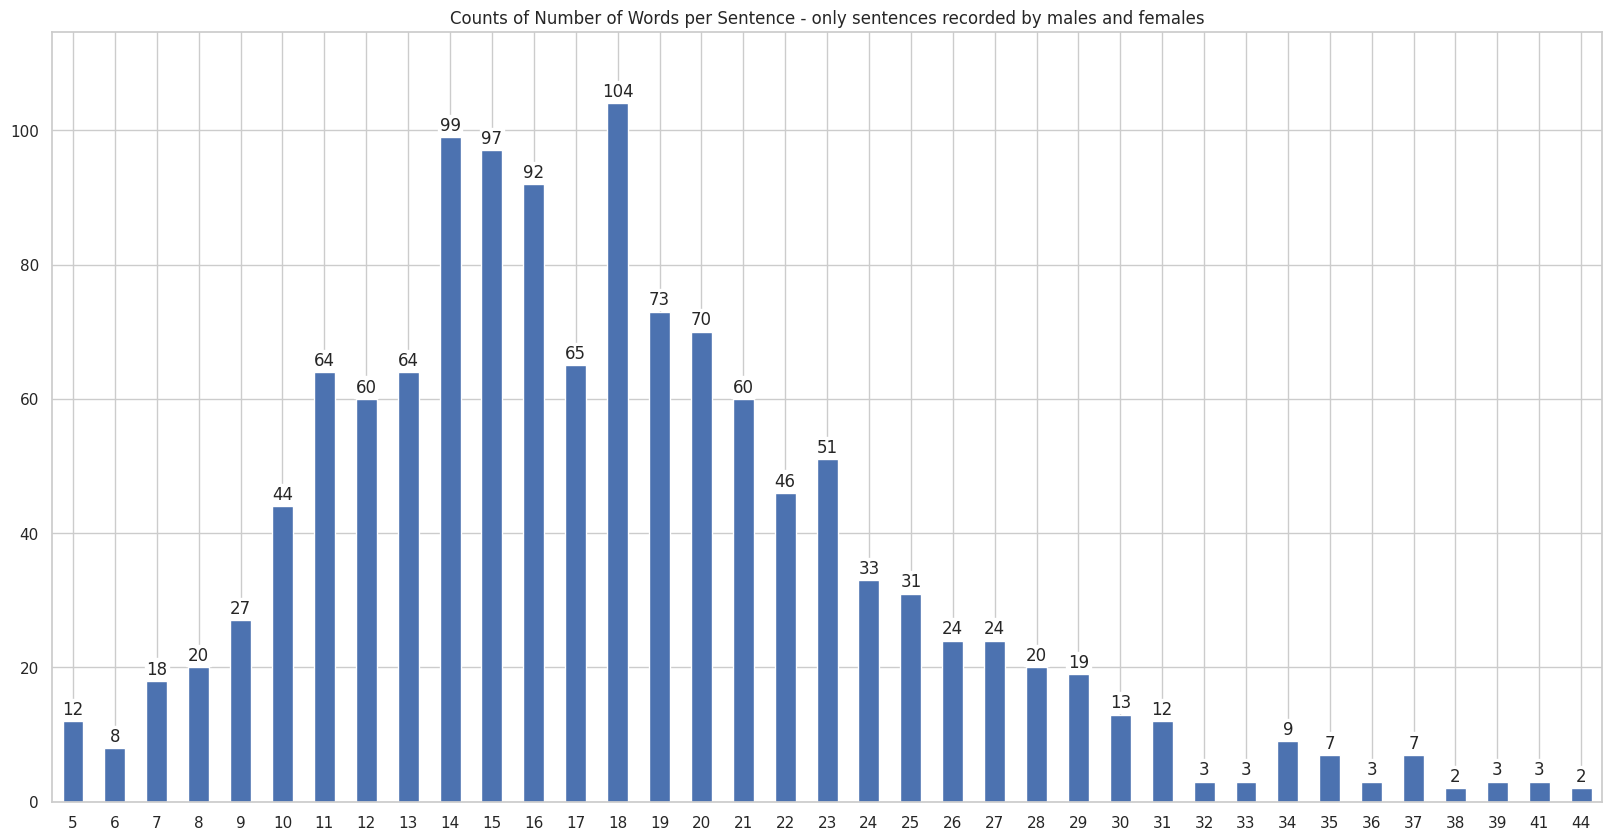

In [ ]:
ax = bisk_plot.plot_word_counts(
    df[df[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL]],
    GROUND_TRUTH_COL,
    'Counts of Number of Words per Sentence - only sentences recorded by males and females')

## Analysis of audio clips

* Overall good quality, no bloopers found after hearing ~150 clips.
* Large differences in amplitude - this probably does not pose a problem for ASR, though.
* Several audio samples are inaudible (a voice is heard, but it lacks articulation, as if high frequencies are filtered)

In [ ]:
df['sample_rate'].value_counts()

16000    3101
Name: sample_rate, dtype: int64

## Speech recognition

Below are examples of running ASR, specifically for the Whisper and MMS models.

**Subsequent commands assume that predictions from each model are merged into a single file** (`DATA_WITH_PREDICTIONS_FILEPATH`).

In [ ]:
!python "$SRC_DIRPATH"'/predict_whisper.py' \
  '--audio-path' "$DATA_DIRPATH" \
  '--sentences-path' "$PREPROCESSED_DATA_FILEPATH" \
  '--model-size' 'medium' \
  '--output-path' "$DATA_WITH_PREDICTIONS_FILEPATH"

In [ ]:
!python "$SRC_DIRPATH"'/predict_whisper.py' \
  '--audio-path' "$DATA_DIRPATH" \
  '--sentences-path' "$PREPROCESSED_DATA_FILEPATH" \
  '--model-size' 'large' \
  '--output-path' "$DATA_WITH_PREDICTIONS_FILEPATH"

In [ ]:
!python "$SRC_DIRPATH"'/predict_meta_mms.py' \
  '--audio-path' "$DATA_DIRPATH" \
  '--sentences-path' "$PREPROCESSED_DATA_FILEPATH" \
  '--output-path' "$DATA_WITH_PREDICTIONS_FILEPATH"

## Computing metrics

Some models may be trained on one of the examined datasets. In particular, one of the datasets the MMS model is trained on is FLEURS. We therefore need to compute metrics using only the test set to avoid reporting biased results when the model is trained on the same data under evaluation. To do so, specify the `--include-test-set-only-scenarios` flag for the `compute_metrics.py` script.

In [ ]:
!python "$SRC_DIRPATH"'/compute_metrics.py' \
  '--predictions-path' "$DATA_WITH_PREDICTIONS_FILEPATH" \
  '--output-dirpath' "$METRICS_DIRPATH" \
  '--include-test-set-only-scenarios'

## Interpreting metrics

In [ ]:
df_metrics = pd.read_parquet(os.path.join(METRICS_DIRPATH, 'metrics_lite.parquet'))
# Empty columns can occur when a subcategory is not available in the dataset,
# e.g. there could be male samples from the age group 'twenties',
# but no female samples from this age group.
df_metrics = df_metrics.dropna(axis=1, how='all')

In [ ]:
df_metrics.head()

,wer_micro_average_whisper-medium_lang-sk_male_and_female,wer_macro_average_whisper-medium_lang-sk_male_and_female,cer_micro_average_whisper-medium_lang-sk_male_and_female,cer_macro_average_whisper-medium_lang-sk_male_and_female,wer_micro_average_whisper-medium_lang-auto_male_and_female,wer_macro_average_whisper-medium_lang-auto_male_and_female,cer_micro_average_whisper-medium_lang-auto_male_and_female,cer_macro_average_whisper-medium_lang-auto_male_and_female,wer_micro_average_whisper-large_lang-sk_male_and_female,wer_macro_average_whisper-large_lang-sk_male_and_female,...,cer_micro_average_whisper-large_lang-auto_recorded_by_male_and_female__female_only__test_set,cer_macro_average_whisper-large_lang-auto_recorded_by_male_and_female__female_only__test_set,wer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__test_set,wer_macro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__test_set,cer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__test_set,cer_macro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__test_set,wer_micro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__test_set,wer_macro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__test_set,cer_micro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__test_set,cer_macro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__test_set
0,0.215486,0.221585,0.059120,0.060273,0.221733,0.230196,0.061205,0.063138,0.142950,0.147505,...,0.042780,0.043707,0.094434,0.097491,0.023064,0.023981,0.397211,0.394226,0.087639,0.087587
1,0.214333,0.220764,0.059273,0.060248,0.225131,0.233480,0.062998,0.064677,0.141994,0.146634,...,0.050339,0.052377,0.114728,0.122298,0.033994,0.036050,0.392555,0.389365,0.088148,0.086892
2,0.218861,0.226633,0.057706,0.059613,0.221130,0.231106,0.061024,0.063461,0.145469,0.149742,...,0.046896,0.044447,0.080037,0.085499,0.022141,0.025356,0.406181,0.403639,0.085491,0.083919
3,0.217644,0.224650,0.060203,0.061481,0.227560,0.236666,0.066422,0.067878,0.146515,0.153550,...,0.043040,0.044849,0.089091,0.090461,0.022420,0.023263,0.405628,0.400140,0.096837,0.090265
4,0.220099,0.224787,0.061963,0.062318,0.220940,0.232026,0.060973,0.064342,0.143979,0.147708,...,0.038790,0.040421,0.102994,0.103777,0.031406,0.032328,0.403371,0.398181,0.085191,0.083018


### Summary of results

In [ ]:
df_summary_metrics_0_95 = df_metrics.apply(bisk_metrics.get_confidence_interval_and_mean, alpha=0.95)
df_summary_metrics_0_95.index = ['mean', 'lower 0.95', 'upper 0.95']
df_summary_metrics_0_95 = df_summary_metrics_0_95.T

df_summary_metrics_0_99 = df_metrics.apply(bisk_metrics.get_confidence_interval_and_mean, alpha=0.99)
df_summary_metrics_0_99 = df_summary_metrics_0_99.iloc[1:]
df_summary_metrics_0_99.index = ['lower 0.99', 'upper 0.99']
df_summary_metrics_0_99 = df_summary_metrics_0_99.T

df_summary_metrics = pd.concat([df_summary_metrics_0_95, df_summary_metrics_0_99], axis=1)

df_summary_metrics.T[
  get_filtered_cols(df_metrics, ['wer_', 'lang-sk', 'test_set', 'micro_average', 'recorded_by_male_and_female'])
].T

,mean,lower 0.95,upper 0.95,lower 0.99,upper 0.99
wer_micro_average_whisper-medium_lang-sk_recorded_by_male_and_female__male_and_female__test_set,0.181694,0.169268,0.194120,0.165364,0.198025
wer_micro_average_whisper-large_lang-sk_recorded_by_male_and_female__male_and_female__test_set,0.117098,0.106431,0.127766,0.103079,0.131118
wer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__male_and_female__test_set,0.090977,0.080431,0.101523,0.077117,0.104837
wer_micro_average_whisper-medium_lang-sk_recorded_by_male_and_female__male_only__test_set,0.159095,0.144522,0.173667,0.139943,0.178246
wer_micro_average_whisper-large_lang-sk_recorded_by_male_and_female__male_only__test_set,0.103564,0.092287,0.114842,0.088744,0.118385
wer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__male_only__test_set,0.083395,0.071193,0.095598,0.067359,0.099432
wer_micro_average_whisper-medium_lang-sk_recorded_by_male_and_female__female_only__test_set,0.202692,0.183559,0.221824,0.177548,0.227836
wer_micro_average_whisper-large_lang-sk_recorded_by_male_and_female__female_only__test_set,0.130090,0.112818,0.147361,0.107391,0.152788
wer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__test_set,0.098562,0.081999,0.115124,0.076794,0.120329


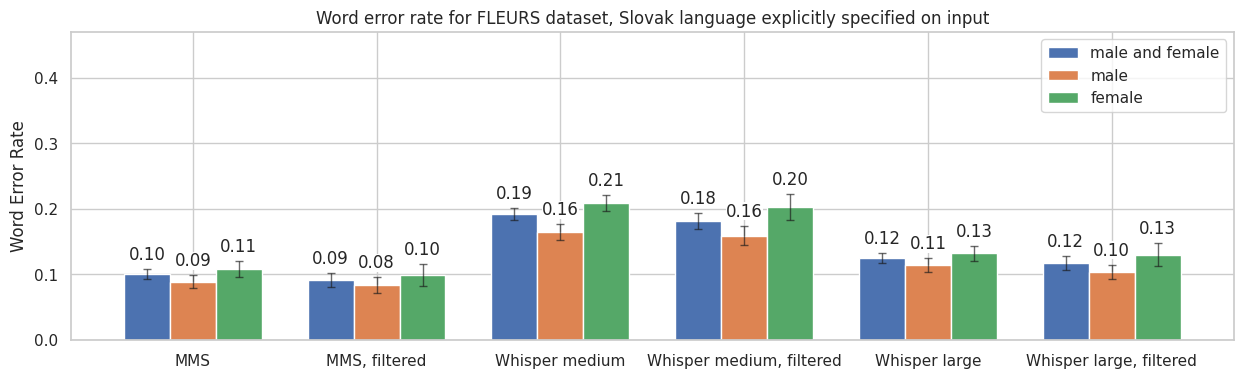

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics,
  affixes_to_match=['wer_', 'lang-sk', 'test_set', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, Slovak language explicitly specified on input',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=0.47,
)

fig

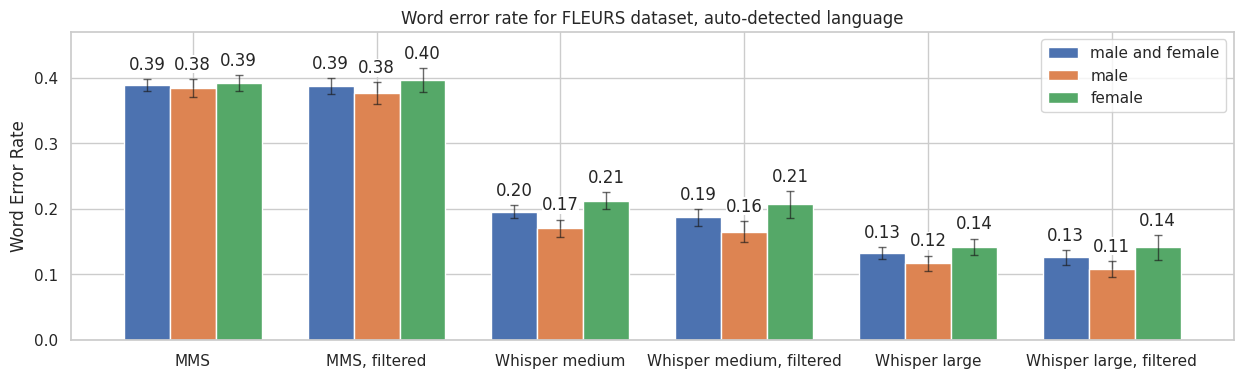

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics,
  affixes_to_match=['wer_', 'lang-auto', 'test_set', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, auto-detected language',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=0.47,
)

fig

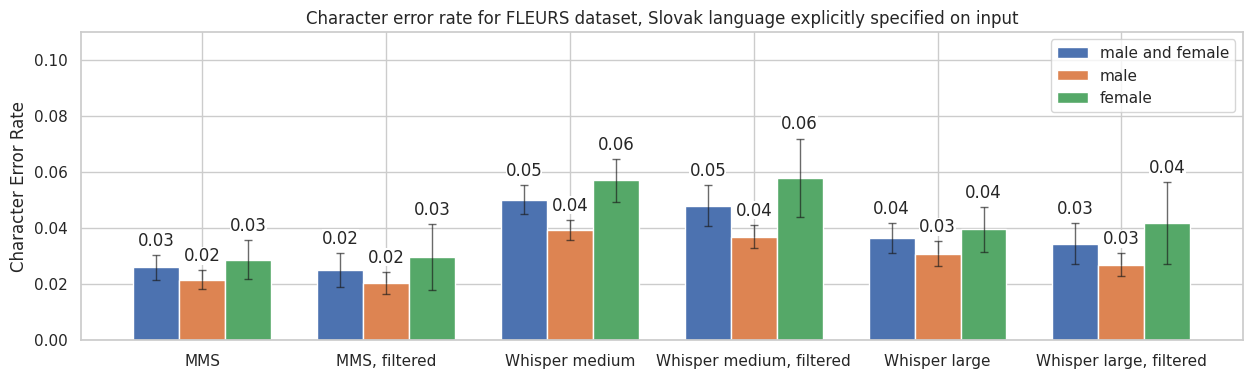

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics,
  affixes_to_match=['cer_', 'lang-sk', 'test_set', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Character error rate for {DATASET_NAME} dataset, Slovak language explicitly specified on input',
  ylabel='Character Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=0.11,
)

fig

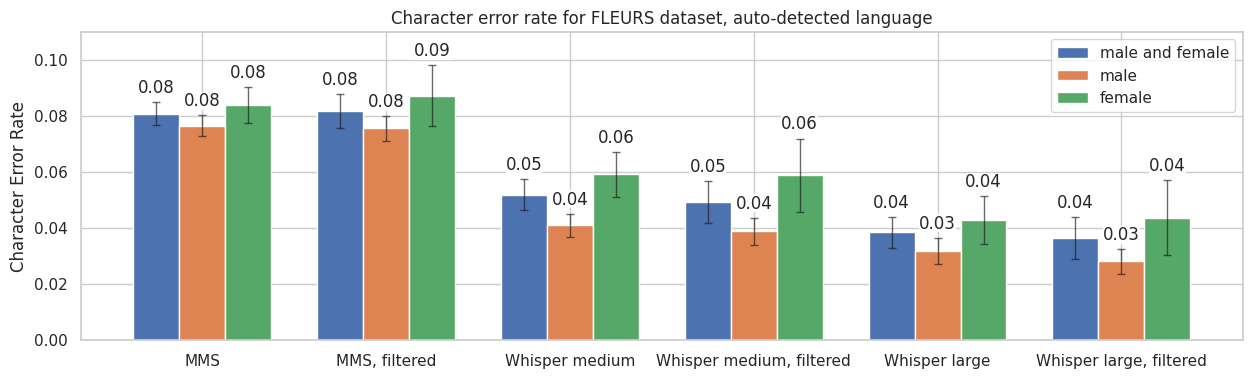

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics,
  affixes_to_match=['cer_', 'lang-auto', 'test_set', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Character error rate for {DATASET_NAME} dataset, auto-detected language',
  ylabel='Character Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=0.11,
)

fig

### Random observations

* Perhaps unsurprisingly, predictions via automatic language detection saw a significant increase in error rates globally.
* MMS model performs well if the language is explicitly specified on input. Conversely, Whisper models perform better if the language is detected automatically compared to MMS.
* For this particular dataset, using only samples recorded by both males and females (`filtered` samples) did not exhibit significant differences in mean error rates compared to using all samples for prediction. However, the confidence intervals have a larger span in the latter case. This could be caused by a lower number of samples in the filtered subset.

# Mozilla Common Voice

## Common variables

In [ ]:
DATA_DIRPATH = COMMON_VOICE_DATA_DIRPATH
CACHE_DIRPATH = os.path.join(DATA_DIRPATH, 'cache')
METRICS_DIRPATH = os.path.join(DATA_DIRPATH, 'metrics')
PREPROCESSED_DATA_FILEPATH = os.path.join(DATA_DIRPATH, 'data_preprocessed.parquet')
DATA_WITH_PREDICTIONS_FILEPATH = os.path.join(DATA_DIRPATH, 'data_with_predictions.parquet')

DATASET_NAME = 'Common Voice'

## Downloading dataset

Download the Common Voice dataset as follows:

1. Go to https://commonvoice.mozilla.org/en/datasets
2. Select the Slovak language
3. Select your desired version of the corpus. This notebook contains results for the corpus named `Common Voice Corpus 13.0`.
4. Fill the required fields and download the selected corpus.
5. Extract the contents of the downloaded archive to the location of your choosing. To run subsequent scripts from this notebook, extract the contents to the `COMMON_VOICE_DATA_DIRPATH` path. You do not need to move up the files from the `cv-corpus-<version>-<date>/sk` subdirectory to the top-level directory.

## Preprocessing dataset

In [ ]:
!python "$SRC_DIRPATH"'/preprocess_common_voice.py' \
  '--data-dirpath' "$DATA_DIRPATH" \
  '--output-path' "$PREPROCESSED_DATA_FILEPATH"

## Basic statistics

In [ ]:
df = pd.read_parquet(PREPROCESSED_DATA_FILEPATH)

In [ ]:
df.head()

,client_id,path,transcription_raw,up_votes,down_votes,age,gender,accents,variant,locale,segment,transcription_target,has_sentence_male_and_female_gender,sample_rate,bits_per_sample,num_channels,num_frames,encoding,audio_resample_success
0,7a92e4da524f310f30cf66dd2d98bb911dc582d0a61b58...,audio/common_voice_sk_36922436.mp3,Súhvezdím prechádza aj časť Mliečnej cesty a j...,2,0,None,unknown,Západné slovensko. Trenčiansky kraj.,NaN,sk,NaN,súhvezdím prechádza aj časť mliečnej cesty a j...,False,32000,0,1,270720,MP3,True
1,84d201a845354dc01202aad4f66f48e0758f9a97266f7a...,audio/common_voice_sk_32320752.mp3,harfistka; hráčka na harfu; harfeníčka,2,0,None,unknown,None,NaN,sk,NaN,harfistka hráčka na harfu harfeníčka,False,32000,0,1,218880,MP3,True
2,aee393cb514ed8ca77aa47cb0d8c70763220adddc4010d...,audio/common_voice_sk_36851819.mp3,Nachádzajú sa vzdušnou čiarou približne východ...,2,0,None,unknown,None,NaN,sk,NaN,nachádzajú sa vzdušnou čiarou približne východ...,False,32000,0,1,196992,MP3,True
3,c6500f50ef884d6dfd34d84d247f9ba4a9f65246d8311f...,audio/common_voice_sk_36920771.mp3,Nikto nemal v dejinách filozofie taký vplyv ak...,2,0,None,unknown,Medzinárodná slovenčina.,NaN,sk,NaN,nikto nemal v dejinách filozofie taký vplyv ak...,False,32000,0,1,199296,MP3,True
4,caa15b0da2b2154c33f572268963a5e787ea1f8a76961e...,audio/common_voice_sk_37209115.mp3,kocur-poznámka - ad veľkosť obrázku,2,0,thirties,male,None,NaN,sk,NaN,kocur-poznámka - ad veľkosť obrázku,False,32000,0,1,172800,MP3,True


In [ ]:
df[GENDER_COL].value_counts(dropna=False)

unknown    9142
male       7354
female     1471
other       255
Name: gender, dtype: int64

In [ ]:
df['age'].value_counts(dropna=False)

None        9204
thirties    4099
fourties    1912
teens       1727
twenties    1280
Name: age, dtype: int64

In [ ]:
df['age'].value_counts(dropna=False) / len(df)

None        0.505104
thirties    0.224948
fourties    0.104928
teens       0.094776
twenties    0.070245
Name: age, dtype: float64

In [ ]:
(df[[GENDER_COL, 'age']].value_counts(dropna=False)).sort_index()

gender   age     
female   fourties     146
         teens       1204
         thirties      55
         twenties       2
         NaN           64
male     fourties    1766
         teens        507
         thirties    3789
         twenties    1278
         NaN           14
other    thirties     255
unknown  teens         16
         NaN         9126
dtype: int64

In [ ]:
(df[[GENDER_COL, 'age']].value_counts(dropna=False) / len(df)).sort_index()

gender   age     
female   fourties    0.008012
         teens       0.066074
         thirties    0.003018
         twenties    0.000110
         NaN         0.003512
male     fourties    0.096916
         teens       0.027824
         thirties    0.207935
         twenties    0.070135
         NaN         0.000768
other    thirties    0.013994
unknown  teens       0.000878
         NaN         0.500823
dtype: float64

In [ ]:
print('Number of all sentences:', len(df[GROUND_TRUTH_COL]))
print('Number of unique sentences:', len(df[GROUND_TRUTH_COL].unique()))
print('Number of sentences recorded by male or female voice:', len(df[df[GENDER_COL].isin(['male', 'female'])]))
print('Number of unique sentences recorded by male or female voice:', len(df.loc[df[GENDER_COL].isin(['male', 'female']), GROUND_TRUTH_COL].unique()))
print('Number of sentences recorded by both male and female voice:', len(df[df[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL]]))
print(
    'Number of unique sentences recorded by both male and female voice:',
    len(df.loc[df[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL], GROUND_TRUTH_COL].unique()))

Number of all sentences: 18222
Number of unique sentences: 8258
Number of sentences recorded by male or female voice: 8825
Number of unique sentences recorded by male or female voice: 6200
Number of sentences recorded by both male and female voice: 2355
Number of unique sentences recorded by both male and female voice: 831


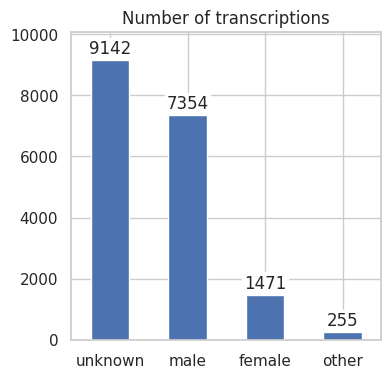

In [ ]:
ax = bisk_plot.plot_counts_per_gender(df, GENDER_COL, 'Number of transcriptions')

In [ ]:
len(df[df[GENDER_COL] == 'unknown']) / len(df[GENDER_COL])

0.5017012402590275

In [ ]:
len(df[df[GENDER_COL] == 'other']) / len(df[GENDER_COL])

0.01399407309845242

<Axes: title={'center': 'Number of transcriptions'}>

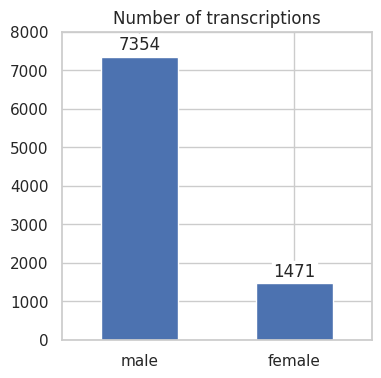

In [ ]:
df_female_and_male_only = df[df[GENDER_COL].isin(['male', 'female'])]

bisk_plot.plot_counts_per_gender(df_female_and_male_only, GENDER_COL, 'Number of transcriptions', ylim=8000)

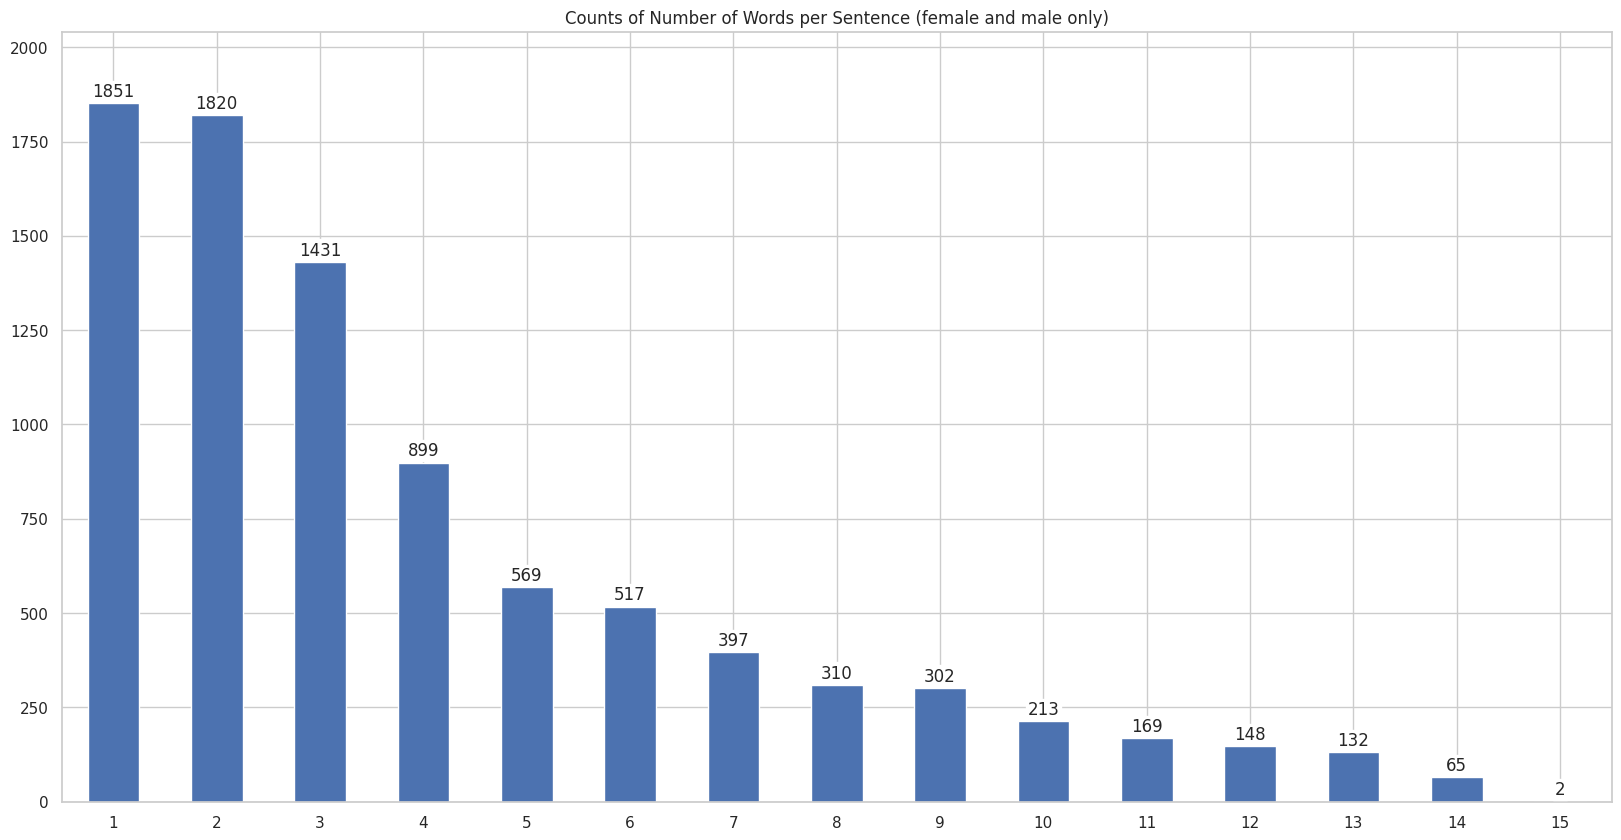

In [ ]:
ax = bisk_plot.plot_word_counts(df_female_and_male_only, GROUND_TRUTH_COL, 'Counts of Number of Words per Sentence (female and male only)')

Percentage of transcriptions having up to _k_ words:

In [ ]:
bisk_preprocessing.get_word_count(df, GROUND_TRUTH_COL).cumsum() / bisk_preprocessing.get_word_count(df, GROUND_TRUTH_COL).sum()

1     0.220064
2     0.443694
3     0.611898
4     0.717155
5     0.777083
6     0.828284
7     0.867248
8     0.897926
9     0.927121
10    0.948359
11    0.965207
12    0.979640
13    0.992921
14    0.999506
15    1.000000
Name: transcription_target, dtype: float64

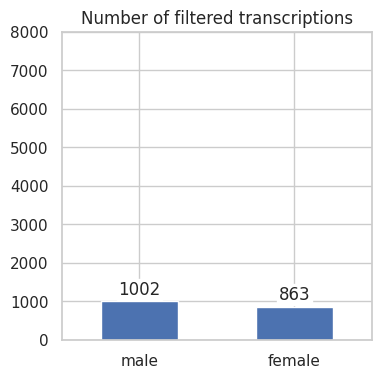

In [ ]:
ax = bisk_plot.plot_counts_per_gender(
    df_female_and_male_only[df_female_and_male_only[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL]],
    GENDER_COL,
    'Number of filtered transcriptions',
    ylim=8000)

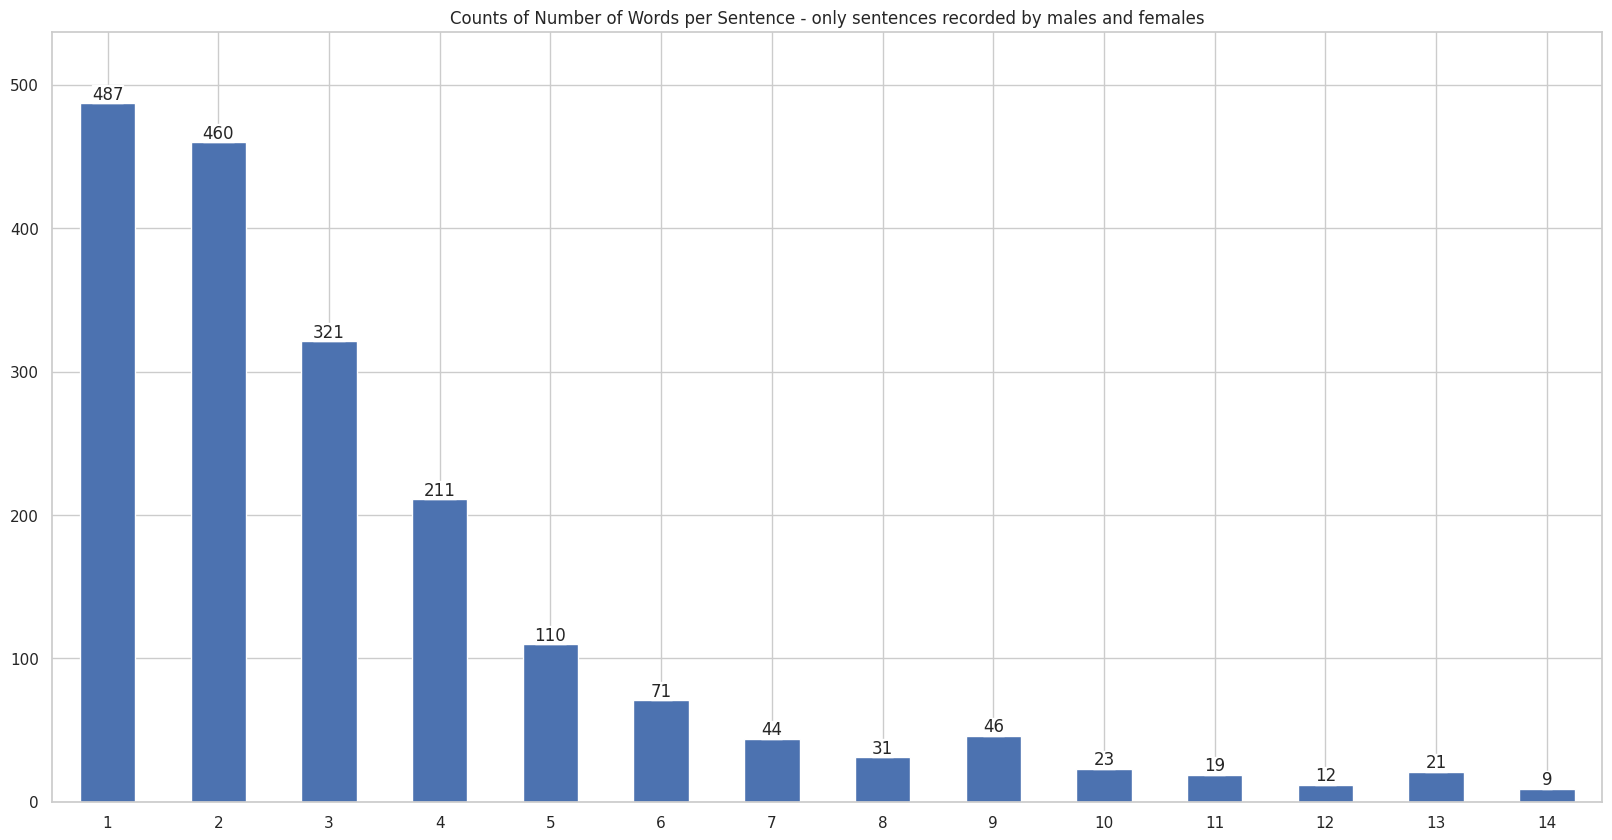

In [ ]:
ax = bisk_plot.plot_word_counts(
    df_female_and_male_only[df_female_and_male_only[HAS_SENTENCE_MALE_AND_FEMALE_GENDER_COL]],
    GROUND_TRUTH_COL,
    'Counts of Number of Words per Sentence - only sentences recorded by males and females')

## Analysis of audio clips

Properties of clips (as perceived by a human):
* intonation - most males have a monotonous voice, females tend to have more varying intonation
* varying degrees of audio quality - some are of good quality, others contain background noise, artifacts due to noise removal, plosives, inaudible start and end of words (mostly only vowels)
* large differences in amplitude - this probably does not pose a problem for ASR, though
* some clips also contain mouse clicks or popping sounds between some syllables
* "cm" is pronounced literally as "c m", not "centimeter"
* a few clips contain mouth opening sounds
* a small number of clips involves rhotacism

Possibly invalid recordings/bloopers (a select few):
* `common_voice_sk_28723292` - blooper
* `common_voice_sk_28723231` - too much background noise
* `common_voice_sk_28723286` - two voices

Difficult to understand, possibly causing increased errors (a select few):
* `common_voice_sk_25002529` - difficult to understand
* `common_voice_sk_28723209` - background noise
* `common_voice_sk_35013086` - difficult to understand
* `common_voice_sk_26860669` - spoken probably with a Czech voice, one word was mispronounced
* `common_voice_sk_28723247` - laughing
* `common_voice_sk_28723271` - background noise
* `common_voice_sk_28723218` - background noise
* `common_voice_sk_28723134` - background noise
* `common_voice_sk_28723293` - background noise, almost laughing
* `common_voice_sk_28563162` - background noise
* `common_voice_sk_28723172` - background noise
* `common_voice_sk_27111564` - baby voice
* `common_voice_sk_28657735` - laughing

## Speech recognition

Below are examples of running ASR, specifically for the Whisper and MMS models.

**Subsequent commands assume that predictions from each model are merged into a single file** (`DATA_WITH_PREDICTIONS_FILEPATH`).

In [ ]:
!python "$SRC_DIRPATH"'/predict_whisper.py' \
  '--audio-path' "$DATA_DIRPATH" \
  '--sentences-path' "$PREPROCESSED_DATA_FILEPATH" \
  '--model-size' 'medium' \
  '--output-path' "$DATA_WITH_PREDICTIONS_FILEPATH"

In [ ]:
!python "$SRC_DIRPATH"'/predict_whisper.py' \
  '--audio-path' "$DATA_DIRPATH" \
  '--sentences-path' "$PREPROCESSED_DATA_FILEPATH" \
  '--model-size' 'large' \
  '--output-path' "$DATA_WITH_PREDICTIONS_FILEPATH"

In [ ]:
!python "$SRC_DIRPATH"'/predict_meta_mms.py' \
  '--audio-path' "$DATA_DIRPATH" \
  '--sentences-path' "$PREPROCESSED_DATA_FILEPATH" \
  '--output-path' "$DATA_WITH_PREDICTIONS_FILEPATH"

## Computing metrics

In [ ]:
!python "$SRC_DIRPATH"'/compute_metrics.py' \
  '--predictions-path' "$DATA_WITH_PREDICTIONS_FILEPATH" \
  '--output-dirpath' "$METRICS_DIRPATH"

## Interpreting metrics

In [ ]:
df_metrics = pd.read_parquet(os.path.join(METRICS_DIRPATH, 'metrics_lite.parquet'))
# Empty columns can occur when a subcategory is not available in the dataset,
# e.g. there could be male samples from age group 'twenties',
# but no female samples from this age group.
df_metrics = df_metrics.dropna(axis=1, how='all')

df_metrics_male_and_female_only = df_metrics[
    [col for col in df_metrics.columns if '__age_' not in col and '_all_genders' not in col]]

In [ ]:
df_metrics_male_and_female_only.head()

,wer_micro_average_whisper-medium_lang-sk_male_and_female,wer_macro_average_whisper-medium_lang-sk_male_and_female,cer_micro_average_whisper-medium_lang-sk_male_and_female,cer_macro_average_whisper-medium_lang-sk_male_and_female,wer_micro_average_whisper-medium_lang-auto_male_and_female,wer_macro_average_whisper-medium_lang-auto_male_and_female,cer_micro_average_whisper-medium_lang-auto_male_and_female,cer_macro_average_whisper-medium_lang-auto_male_and_female,wer_micro_average_whisper-large_lang-sk_male_and_female,wer_macro_average_whisper-large_lang-sk_male_and_female,...,cer_micro_average_whisper-large_lang-auto_recorded_by_male_and_female__female_only,cer_macro_average_whisper-large_lang-auto_recorded_by_male_and_female__female_only,wer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only,wer_macro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only,cer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only,cer_macro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only,wer_micro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only,wer_macro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only,cer_micro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only,cer_macro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only
0,0.412703,0.560576,0.108652,0.156059,0.508386,0.714459,0.183172,0.301577,0.323330,0.468258,...,0.324740,0.497118,0.464748,0.849051,0.166900,0.412672,1.027266,1.781251,0.295281,0.634290
1,0.416058,0.556892,0.112275,0.158486,0.502928,0.714191,0.180061,0.293982,0.324512,0.469316,...,0.347046,0.524538,0.486477,0.885086,0.173796,0.447176,0.887684,1.488305,0.254026,0.527471
2,0.421993,0.568597,0.115884,0.164142,0.512640,0.727451,0.181426,0.307681,0.319617,0.459849,...,0.348113,0.533470,0.447396,0.791307,0.157340,0.381761,0.918769,1.577307,0.262044,0.560711
3,0.409884,0.549567,0.106841,0.150842,0.500277,0.709101,0.179783,0.297338,0.320057,0.465271,...,0.335501,0.485436,0.450156,0.781268,0.151799,0.387281,0.947920,1.614388,0.260096,0.537679
4,0.407638,0.546150,0.107213,0.153685,0.505130,0.713031,0.179988,0.292930,0.321171,0.456891,...,0.283141,0.395376,0.502131,0.877767,0.191813,0.487738,0.938804,1.574038,0.262056,0.538492


### Summary of results

In [ ]:
df_summary_metrics_0_95 = df_metrics_male_and_female_only.apply(bisk_metrics.get_confidence_interval_and_mean, alpha=0.95)
df_summary_metrics_0_95.index = ['mean', 'lower 0.95', 'upper 0.95']
df_summary_metrics_0_95 = df_summary_metrics_0_95.T

df_summary_metrics_0_99 = df_metrics_male_and_female_only.apply(bisk_metrics.get_confidence_interval_and_mean, alpha=0.99)
df_summary_metrics_0_99 = df_summary_metrics_0_99.iloc[1:]
df_summary_metrics_0_99.index = ['lower 0.99', 'upper 0.99']
df_summary_metrics_0_99 = df_summary_metrics_0_99.T

df_summary_metrics = pd.concat([df_summary_metrics_0_95, df_summary_metrics_0_99], axis=1)

df_summary_metrics.T[get_filtered_cols(df_metrics_male_and_female_only, ['wer_', 'lang-sk', 'micro_average', 'male_only'])].T

,mean,lower 0.95,upper 0.95,lower 0.99,upper 0.99
wer_micro_average_whisper-medium_lang-sk_male_only,0.396263,0.387865,0.404660,0.385226,0.407299
wer_micro_average_whisper-large_lang-sk_male_only,0.305849,0.297524,0.314173,0.294908,0.316789
wer_micro_average_meta-mms_lang-sk_male_only,0.310669,0.300042,0.321295,0.296703,0.324634
wer_micro_average_whisper-medium_lang-sk_female_only,0.513915,0.476953,0.550876,0.465339,0.562490
wer_micro_average_whisper-large_lang-sk_female_only,0.413873,0.382420,0.445326,0.372537,0.455209
wer_micro_average_meta-mms_lang-sk_female_only,0.439064,0.405016,0.473111,0.394318,0.483809
wer_micro_average_whisper-medium_lang-sk_recorded_by_male_and_female__male_only,0.427538,0.400634,0.454441,0.392180,0.462895
wer_micro_average_whisper-large_lang-sk_recorded_by_male_and_female__male_only,0.327890,0.304220,0.351561,0.296783,0.358998
wer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__male_only,0.331681,0.298359,0.365004,0.287888,0.375475
wer_micro_average_whisper-medium_lang-sk_recorded_by_male_and_female__female_only,0.541091,0.480353,0.601828,0.461268,0.620913


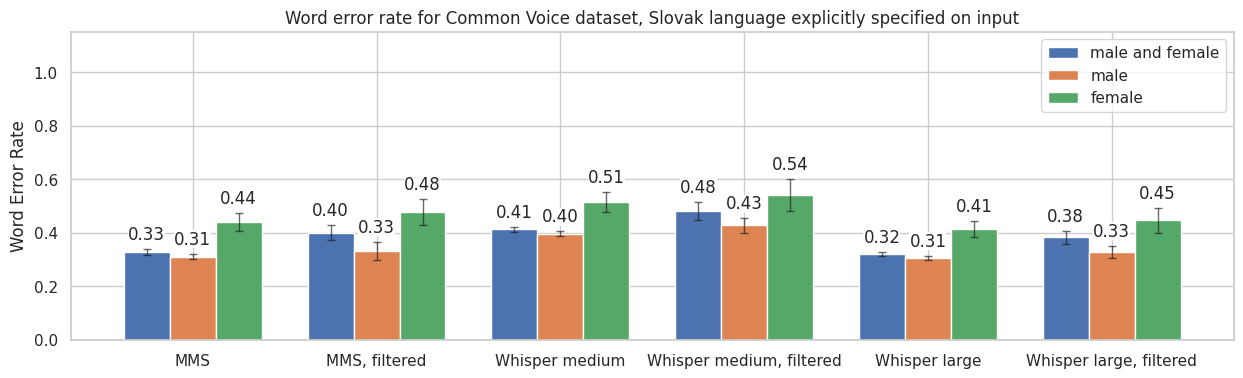

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_male_and_female_only,
  affixes_to_match=['wer_', 'lang-sk', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, Slovak language explicitly specified on input',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=1.15,
)

fig

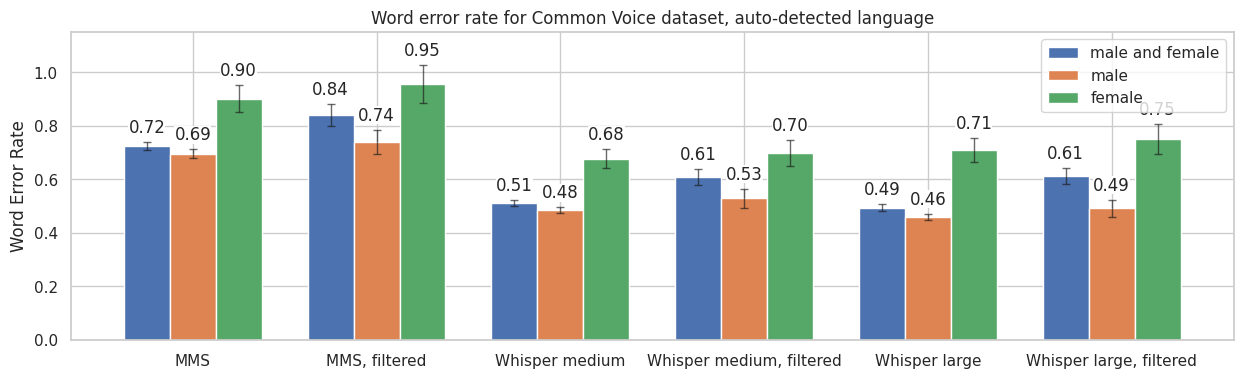

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_male_and_female_only,
  affixes_to_match=['wer_', 'lang-auto', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, auto-detected language',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=1.15,
)

fig

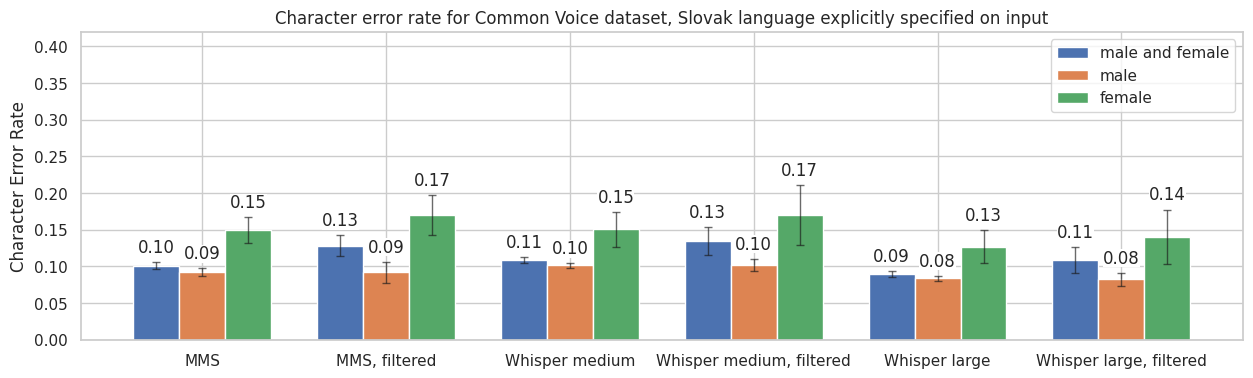

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_male_and_female_only,
  affixes_to_match=['cer_', 'lang-sk', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Character error rate for {DATASET_NAME} dataset, Slovak language explicitly specified on input',
  ylabel='Character Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=0.42,
)

fig

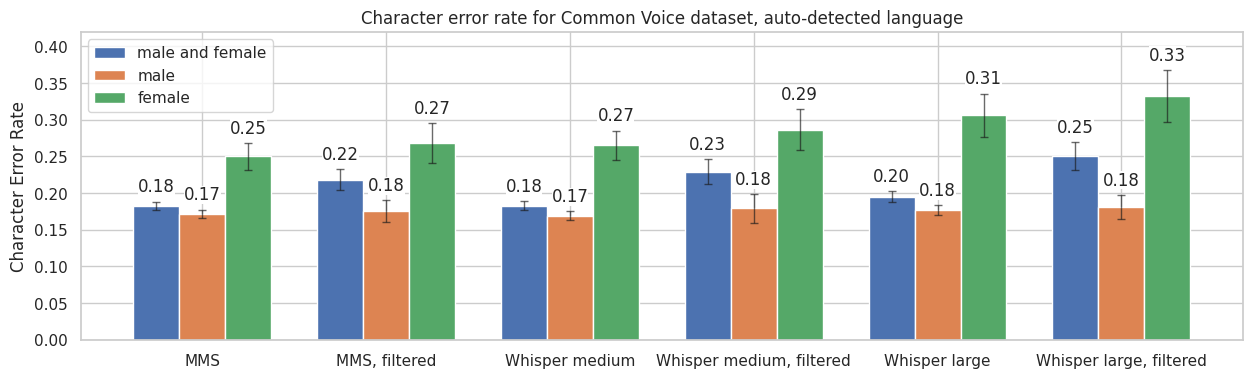

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_male_and_female_only,
  affixes_to_match=['cer_', 'lang-auto', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Character error rate for {DATASET_NAME} dataset, auto-detected language',
  ylabel='Character Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=0.42,
)

fig

### Summary of results per age group

#### Teenagers

In [ ]:
df_metrics_teens = df_metrics[
    [col for col in df_metrics.columns if '__age_teens' in col and '_all_genders' not in col]]

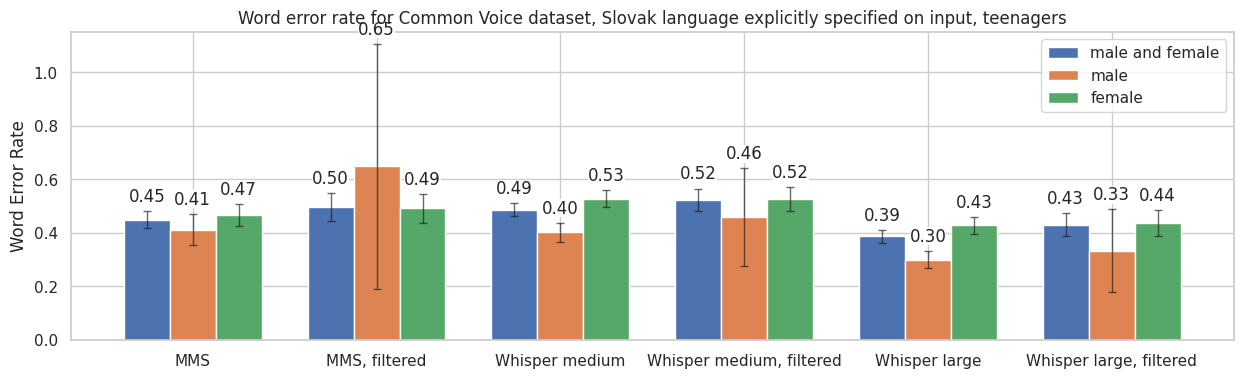

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_teens,
  affixes_to_match=['wer_', 'lang-sk', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, Slovak language explicitly specified on input, teenagers',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=1.15,
)

fig

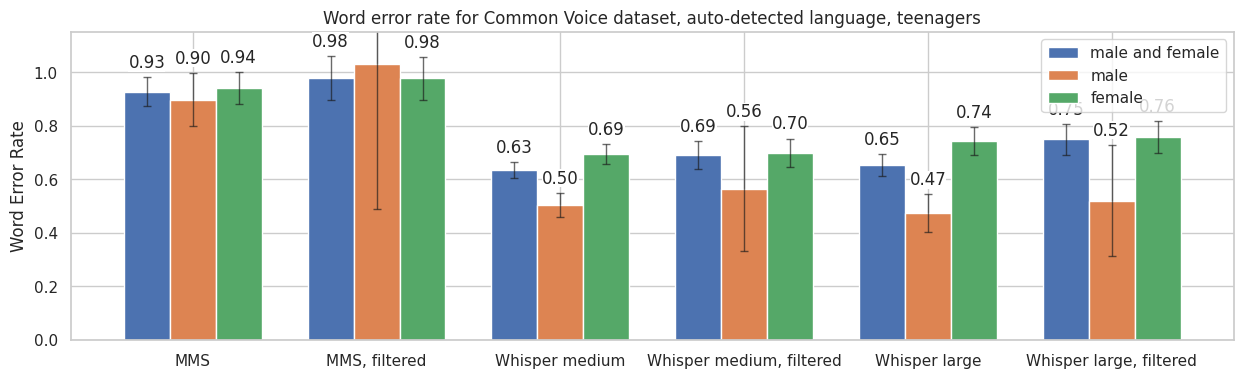

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_teens,
  affixes_to_match=['wer_', 'lang-auto', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, auto-detected language, teenagers',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=1.15,
)

fig

#### Thirties

In [ ]:
df_metrics_thirties = df_metrics[
    [col for col in df_metrics.columns if '__age_thirties' in col and '_all_genders' not in col]]

In [ ]:
df_metrics_thirties

,wer_micro_average_whisper-medium_lang-sk_male_and_female__age_thirties,wer_macro_average_whisper-medium_lang-sk_male_and_female__age_thirties,cer_micro_average_whisper-medium_lang-sk_male_and_female__age_thirties,cer_macro_average_whisper-medium_lang-sk_male_and_female__age_thirties,wer_micro_average_whisper-medium_lang-auto_male_and_female__age_thirties,wer_macro_average_whisper-medium_lang-auto_male_and_female__age_thirties,cer_micro_average_whisper-medium_lang-auto_male_and_female__age_thirties,cer_macro_average_whisper-medium_lang-auto_male_and_female__age_thirties,wer_micro_average_whisper-large_lang-sk_male_and_female__age_thirties,wer_macro_average_whisper-large_lang-sk_male_and_female__age_thirties,...,cer_micro_average_whisper-large_lang-auto_recorded_by_male_and_female__female_only__age_thirties,cer_macro_average_whisper-large_lang-auto_recorded_by_male_and_female__female_only__age_thirties,wer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__age_thirties,wer_macro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__age_thirties,cer_micro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__age_thirties,cer_macro_average_meta-mms_lang-sk_recorded_by_male_and_female__female_only__age_thirties,wer_micro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__age_thirties,wer_macro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__age_thirties,cer_micro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__age_thirties,cer_macro_average_meta-mms_lang-auto_recorded_by_male_and_female__female_only__age_thirties
0,0.423920,0.566967,0.110019,0.155926,0.538202,0.772809,0.198873,0.329336,0.332602,0.477968,...,0.102434,0.220159,0.241935,0.285714,0.054945,0.092800,0.975309,1.452381,0.236984,0.440403
1,0.426674,0.578789,0.111828,0.156642,0.529412,0.759329,0.186888,0.311639,0.336545,0.484276,...,0.130031,0.154875,0.437500,0.530896,0.116959,0.245637,0.702970,0.909524,0.165746,0.251097
2,0.431411,0.588958,0.112437,0.160026,0.530306,0.757654,0.188119,0.330035,0.326963,0.463604,...,0.112376,0.148982,0.396396,0.386196,0.086788,0.137723,0.753968,0.941156,0.172531,0.248204
3,0.421252,0.571278,0.107635,0.156272,0.525373,0.744333,0.188780,0.315942,0.330973,0.477454,...,0.174679,0.239915,0.361446,0.564484,0.171076,0.464303,0.735849,0.966837,0.142287,0.247926
4,0.417570,0.547784,0.107797,0.145331,0.529797,0.750959,0.191389,0.317520,0.335193,0.477223,...,0.118527,0.173378,0.340659,0.378118,0.068333,0.103146,0.908046,1.121429,0.202853,0.315662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.426146,0.571250,0.109445,0.152766,0.521590,0.744476,0.191554,0.309559,0.330126,0.474253,...,0.125149,0.201034,0.458333,0.537840,0.085507,0.174905,0.955556,1.240476,0.215873,0.339632
996,0.433573,0.588430,0.113126,0.162298,0.525745,0.752721,0.191094,0.315101,0.328979,0.472435,...,0.180108,0.269256,0.446154,0.439626,0.140940,0.219774,0.740385,1.094048,0.158602,0.293042
997,0.425553,0.569333,0.109406,0.153022,0.536936,0.760950,0.189707,0.313328,0.332709,0.481553,...,0.125529,0.198428,0.200000,0.188492,0.035294,0.035105,0.693878,0.822619,0.149584,0.212996
998,0.432922,0.577308,0.109802,0.152952,0.526902,0.761791,0.194552,0.326640,0.330400,0.487513,...,0.152116,0.178308,0.379747,0.432823,0.070690,0.125994,0.783784,0.979252,0.164141,0.226180


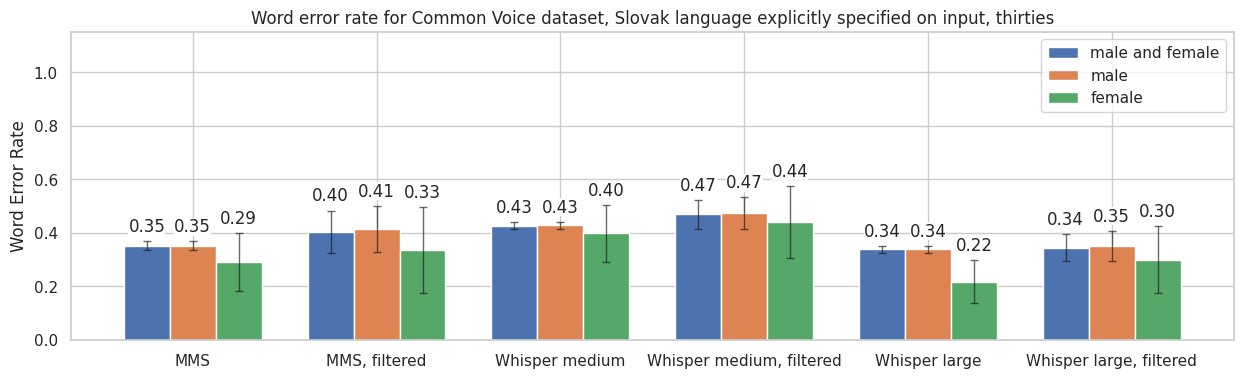

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_thirties,
  affixes_to_match=['wer_', 'lang-sk', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, Slovak language explicitly specified on input, thirties',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=1.15,
)

fig

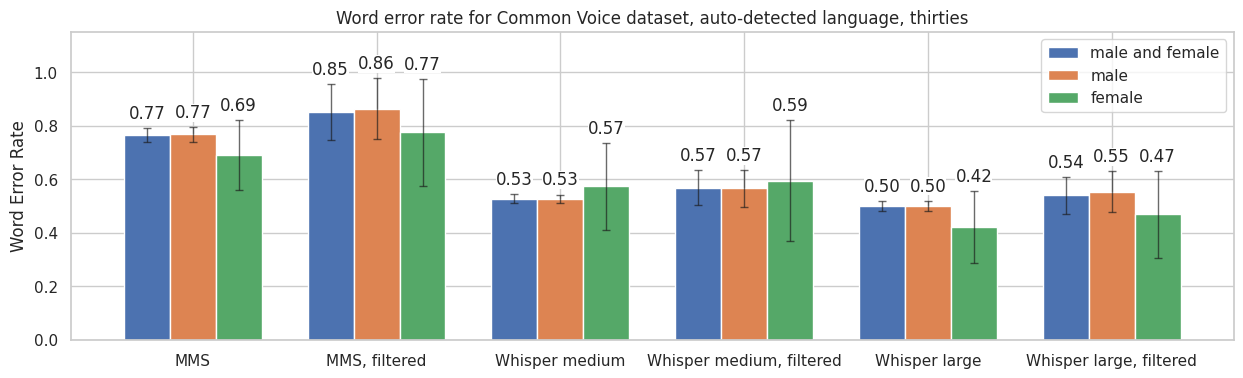

In [ ]:
fig, ax = bisk_plot.plot_bars(
  df_metrics_thirties,
  affixes_to_match=['wer_', 'lang-auto', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    [lambda col: 'recorded_by_male_and_female' not in col, 'recorded_by_male_and_female'],
  ],
  group_names=['MMS', 'MMS, filtered', 'Whisper medium', 'Whisper medium, filtered', 'Whisper large', 'Whisper large, filtered'],
  within_group_names=['male and female', 'male', 'female'],
  title=f'Word error rate for {DATASET_NAME} dataset, auto-detected language, thirties',
  ylabel='Word Error Rate',
  alpha=0.95,
  figsize=(15, 4),
  x_label_rotation=0,
  ylim=1.15,
)

fig

### Random observations

* Overall, models perform poorly on the Common Voice dataset. Factors that _could_ influence the performance include low (albeit much more realistic) audio quality (particularly background noise) and possibly short length of individual recordings which might not be enough for models to yield correct transcriptions. These are only hypotheses and further investigation is required.
* This further confirms that MMS has trouble recognizing the Slovak language.
* When considering all data, models consistently yield higher error rates for females, indicating gender bias.
* When only considering samples for the `thirties` age group, females tend to perform better. However, the high confidence intervals suggest a lack of samples for females in this age group.

# Summary of results for the report

In [ ]:
sns.reset_defaults()

In [ ]:
df_fleurs_metrics = pd.read_parquet(
    os.path.join(FLEURS_DATA_DIRPATH, 'metrics', 'metrics_lite.parquet'))
df_fleurs_metrics = df_fleurs_metrics.dropna(axis=1, how='all')

df_common_voice_metrics = pd.read_parquet(
    os.path.join(COMMON_VOICE_DATA_DIRPATH, 'metrics', 'metrics_lite.parquet'))
df_common_voice_metrics = df_common_voice_metrics.dropna(axis=1, how='all')
df_common_voice_metrics = df_common_voice_metrics[
    [col for col in df_common_voice_metrics.columns if '__age_' not in col and '_all_genders' not in col]]

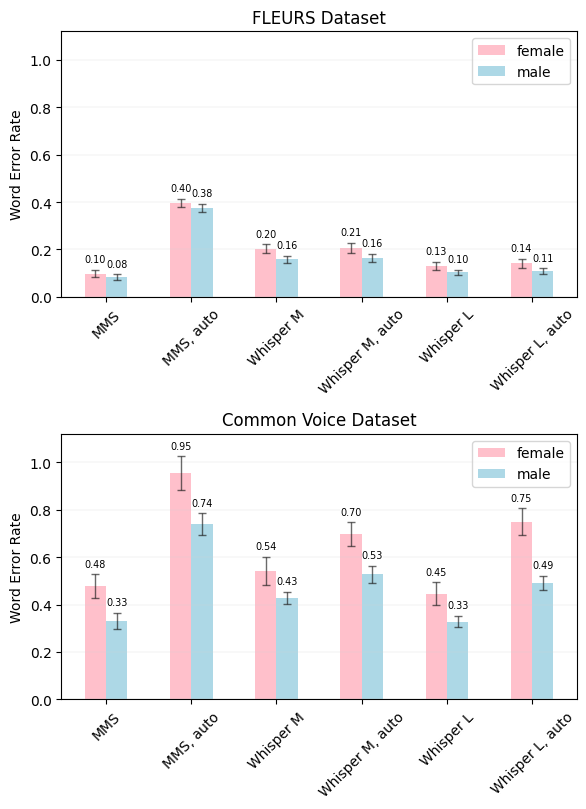

In [ ]:
fig_for_report, axes_for_report = plt.subplots(2, 1)

fig_for_report.set_size_inches(6, 8.2)

bisk_plot.plot_bars(
  df_fleurs_metrics,
  ax=axes_for_report[0],
  affixes_to_match=['wer_', 'recorded_by_male_and_female', 'test_set', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    ['lang-sk', 'lang-auto'],
  ],
  group_names=['MMS', 'MMS, auto', 'Whisper M', 'Whisper M, auto', 'Whisper L', 'Whisper L, auto'],
  within_group_names=['male and female', 'male', 'female'],
  title='FLEURS Dataset',
  ylabel='Word Error Rate',
  within_group_name_filter=[2, 1],
  alpha=0.95,
  x_label_rotation=45,
  ylim=1.12,
  colors=['palegreen', 'pink', 'lightblue'],
  custom_grid=True,
  bar_label_font_size='x-small',
)

bisk_plot.plot_bars(
  df_common_voice_metrics,
  ax=axes_for_report[1],
  affixes_to_match=['wer_', 'recorded_by_male_and_female', 'micro_average'],
  affixes_for_splitting=[
    ['meta-mms', 'whisper-medium', 'whisper-large'],
    ['lang-sk', 'lang-auto'],
  ],
  group_names=['MMS', 'MMS, auto', 'Whisper M', 'Whisper M, auto', 'Whisper L', 'Whisper L, auto'],
  within_group_names=['male and female', 'male', 'female'],
  title='Common Voice Dataset',
  ylabel='Word Error Rate',
  within_group_name_filter=[2, 1],
  alpha=0.95,
  x_label_rotation=45,
  ylim=1.12,
  colors=['palegreen', 'pink', 'lightblue'],
  custom_grid=True,
  bar_label_font_size='x-small',
)

fig_for_report.tight_layout()
fig_for_report.savefig(os.path.join(ROOT_DIRPATH, 'speech_to_text_WERs.png'), dpi=300)
fig_for_report